## AIDS

In *message passing simplicial networks* they benchmark using some data sets from TUdatasets. Here we try the PROTEINS dataset. See "Protein Function Prediction via Graph Kernels", Bogwart et al., for details about the data set. 

There are two classes of graphs: *enzymes* and *not enzymes*

The data set has node features in $\{0,1 \}^3$ . 

### Todo: 
- Check initialization of cochains: I think right now its random 
- Try different models,  maybe more convolutional layers or higher powers of L 

In [1]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.datasets import TUDataset
import networkx as nx
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import numpy as np
  
import cochainlearning as cl

ModuleNotFoundError: No module named 'torch'

# Load the dataset

In [2]:
# dataset
dataset = TUDataset(root='tudata/TUDataset', name='BZR')
dataset

Extracting tudata/TUDataset/BZR/BZR.zip
Processing...
Done!


BZR(405)

In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: BZR(405):
Number of graphs: 405
Number of features: 53
Number of classes: 2

Data(edge_index=[2, 64], x=[30, 53], y=[1])
Number of nodes: 30
Number of edges: 64
Average node degree: 2.13
Has isolated nodes: False
Has self-loops: False
Is undirected: True


#### Separate data into training and testing 

In [5]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

len_train_set = 340
train_dataset = dataset[:len_train_set]
test_dataset = dataset[len_train_set:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 340
Number of test graphs: 65


#### Make clique complexess with the graphs
clique complexes up to dimension 2 

In [6]:
def graph_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = torch.tensor(graph['x'])

    # get edges
    edge_index =torch.tensor(data['edge_index']).T

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

# example
chainz = []
for i in range(len(dataset)):
    data = dataset[i]

    chainz.append(graph_to_chain(data))

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_4246/1412791142.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(graph['x'])
/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_4246/1412791142.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index =torch.tensor(data['edge_index']).T
/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_4246/1412791142.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/

## Train a model

In [7]:
class model(nn.Module):  
    
    """Define a simple model using convolutional layers and linear layers 
    to reduce the dim of the output """
    
    
    def __init__(self, n, out, c = 5, m1 = 20, m2 = 10, m3 = 20, m4 = 10): ## check channel sizes
        super().__init__()
        self.n = n
        self.c = c
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3

        # initialise vector field
        self.vf = nn.Sequential(
                    nn.Linear(n, m1),
                    nn.ReLU(),
                    nn.Linear(m1, m2),
                    nn.ReLU(),
                    nn.Linear(m2, n*c)
                    )
        
        # initialise MLP classifier
        self.classifier = nn.Sequential(
                    nn.Linear(c, m3),
                    nn.ReLU(),
                    nn.Linear(m3, m4),
                    nn.ReLU(),
                    nn.Linear(m4, out)
                    )

        
        
    def forward(self, x):
        ## asses the dimensions are correct somewhere 
        "Here the input is a chain, and the output is a vector of probabilities"

        # generate cochain data matrix
        X = cl.gen_CDM(self.vf, x)

        # orientation invariant square L2-norm readout function
        X = torch.diag(X.T @ X)

        # put output through classifier
        output = self.classifier(X)

        # softmax
        sm = nn.functional.softmax(output)
        
        return sm
    
    

In [8]:

n = dataset[0]['x'].shape[1] # cochain feature dimension
out = dataset.num_classes # output dimension


basic_model = model(n = n, out = out)

In [9]:
dataset[0].y

tensor([0])

In [10]:
# print the total number of graphs in each class in the dataset
print('Number of graphs in each class in the dataset:')
print('=============================================================')
for i in range(train_dataset.num_classes):
    print(f'Class {i}: {sum([1 for data in train_dataset if data.y == i])}')

# store the ratio of graphs in each class
class_ratios = torch.tensor([sum([1 for data in train_dataset if data.y == i]) / len(train_dataset) for i in range(train_dataset.num_classes)])

weight_ratios = 1 - class_ratios


Number of graphs in each class in the dataset:
Class 0: 268
Class 1: 72


In [13]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(basic_model.parameters(), lr=1e-2)

criterion = torch.nn.CrossEntropyLoss(weight=weight_ratios)

In [14]:
def train(dataset, chainz):

    
    basic_model.train()

    correct = 0
    L = 0

    for i in range(len(dataset)):  # Iterate in batches over the training dataset.

        chain = chainz[i]
        data = dataset[i]

        out = basic_model.forward(chain)  # Perform a single forward pass.

        # do a 1-hot encoding of data.y
        y = torch.zeros(dataset.num_classes)
        y[data.y] = 1

        # compute if prediction is correct
        if torch.argmax(out) == torch.argmax(y):
            correct += 1
        
        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.

        L += loss.item()

        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        

    return L / len(dataset), correct / len(dataset)



In [15]:
epochs = 100

losses = torch.zeros(epochs)
accuracies = torch.zeros(epochs)

for j in range(epochs):

    L, A = train(train_dataset, chainz)

    losses[j] = L
    accuracies[j] = A
    
    print("Epoch = ", j, "Loss = ", L, "Accuracy = ", A)


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_4246/3356116047.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = nn.functional.softmax(output)


Epoch =  0 Loss =  0.2315793395480689 Accuracy =  0.21176470588235294
Epoch =  1 Loss =  0.23155837646302055 Accuracy =  0.21176470588235294
Epoch =  2 Loss =  0.2315437475548071 Accuracy =  0.21176470588235294
Epoch =  3 Loss =  0.23153352075639894 Accuracy =  0.21176470588235294
Epoch =  4 Loss =  0.2315263436121099 Accuracy =  0.21176470588235294
Epoch =  5 Loss =  0.23152127958395902 Accuracy =  0.21176470588235294
Epoch =  6 Loss =  0.23151767678997096 Accuracy =  0.21176470588235294
Epoch =  7 Loss =  0.2315150806132485 Accuracy =  0.21764705882352942
Epoch =  8 Loss =  0.23151317493003956 Accuracy =  0.2323529411764706
Epoch =  9 Loss =  0.23151174783706666 Accuracy =  0.2411764705882353
Epoch =  10 Loss =  0.23151064243386774 Accuracy =  0.25588235294117645
Epoch =  11 Loss =  0.23150975984685562 Accuracy =  0.27647058823529413
Epoch =  12 Loss =  0.23150902688503266 Accuracy =  0.31470588235294117
Epoch =  13 Loss =  0.23150839284062386 Accuracy =  0.3323529411764706
Epoch =  

In [15]:
# save the basic model to a file
#torch.save(basic_model.state_dict(), 'basic_model.pt')

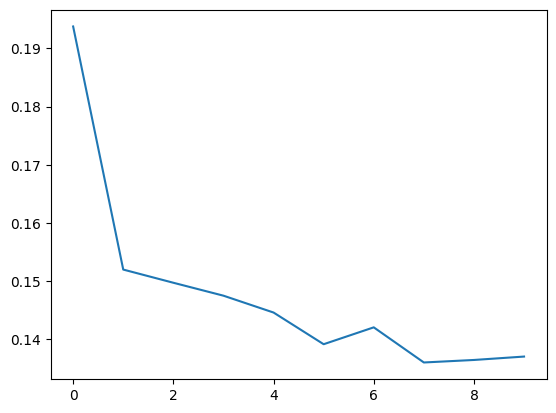

In [13]:
# plot losses
plt.plot(losses)

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_8346/3356116047.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = nn.functional.softmax(output)


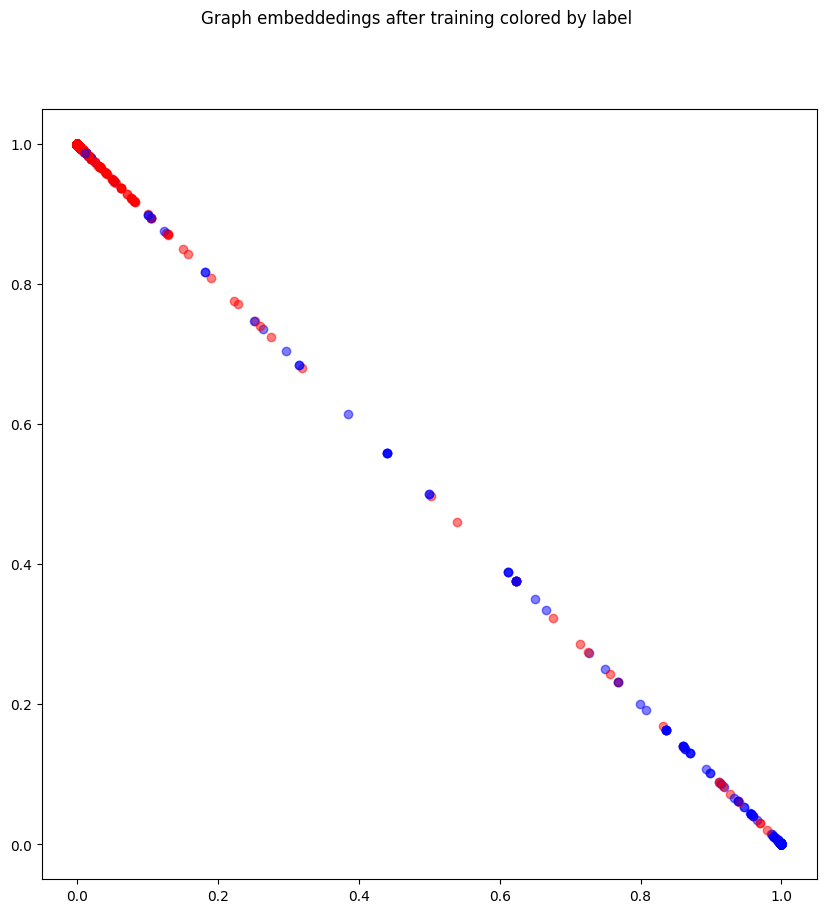

In [14]:
# plot a scatterplot of the predictions

# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

class0 = []
class1 = []

for i in range(len(train_dataset)):
        
        chain = chainz[i]
        data = dataset[i]

        X = basic_model.forward(chain)

        lb = data.y
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), color = 'blue', alpha = 0.5)
            class0.append(X[0].detach().numpy())
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), color = 'red', alpha = 0.5)
            class1.append(X[0].detach().numpy())

# add a title to the figure
fig.suptitle('Graph embeddedings after training colored by label')

plt.show()

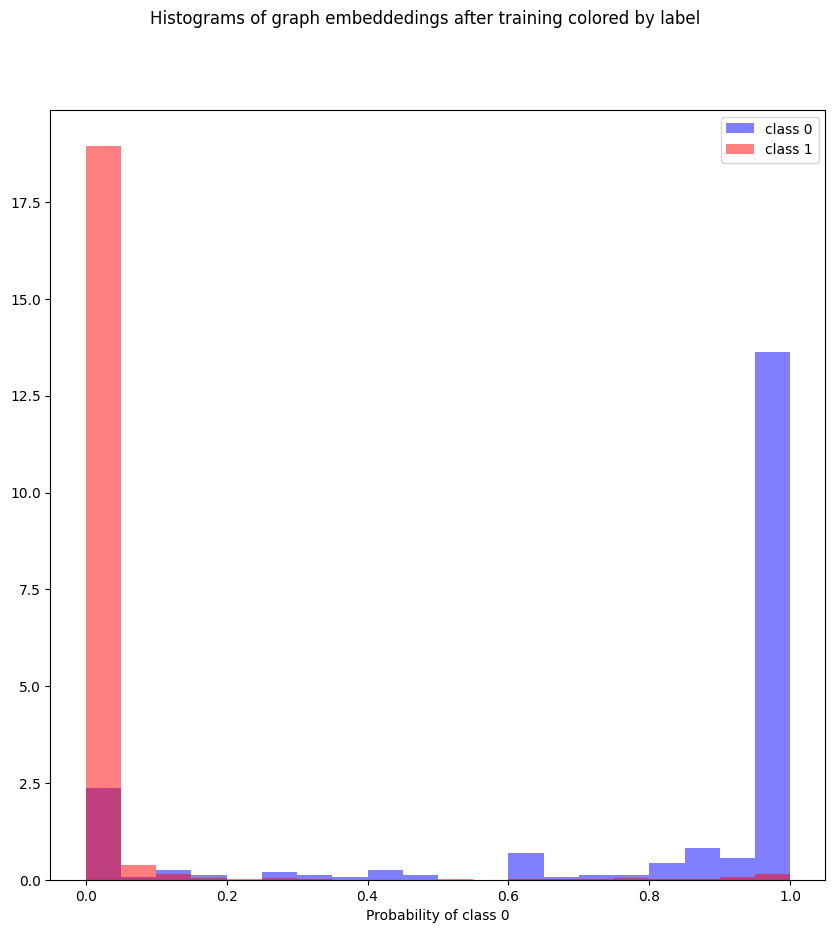

In [15]:
# make histograms with density approximation of class0 and class1 on the same figure
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ax.hist(class0, bins = 20, density = True, color = 'blue', alpha = 0.5, label = 'class 0')
ax.hist(class1, bins = 20, density = True, color = 'red', alpha = 0.5, label = 'class 1')


# add a title to the figure
fig.suptitle('Histograms of graph embeddedings after training colored by label')

plt.legend()

# add a title to the x axis
plt.xlabel('Probability of class 0')

plt.show()


In [16]:
# evaluate the model on the test set
def test(dataset, chainz):

    basic_model.eval()

    correct = 0

    for i in range(len(dataset)):  # Iterate in batches over the training/test dataset.

        chain = chainz[i]
        data = dataset[i]

        out = basic_model.forward(chain)  # Perform a single forward pass.

        # do a 1-hot encoding of data.y
        y = torch.zeros(dataset.num_classes)
        y[data.y] = 1

        # compute if prediction is correct
        if torch.argmax(out) == torch.argmax(y):
            correct += 1

    return correct / len(dataset)



In [17]:
# evaluate the model on the test set
test_chainz = []
for i in range(len(test_dataset)):
    data = test_dataset[i]

    test_chainz.append(graph_to_chain(data))

test_acc = test(test_dataset, test_chainz)



/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_8346/1412791142.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(graph['x'])
/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_8346/1412791142.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index =torch.tensor(data['edge_index']).T
/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_8346/3356116047.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = nn.functional.softmax(output)


In [18]:
test_acc

0.93